<a href="https://colab.research.google.com/github/sayan0506/Deep-Learning-CV-Hackathon/blob/main/Face_Verification_Based_Attendance_System_using_Arcface_Transfer_Learning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Verification using Arcface, Siamese network training using triplet loss**

## **Import Dependencies**

In [1]:
import zipfile
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw

import torch

# **Environment Setup**

#### **Check GPU utilization**

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
print(f'Device info\n{torch.cuda.get_device_properties(0)}')

Device info
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## **Drive mount**

In [4]:
# drive mount
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## **Data Load**

#### Unzipping

Defining the unzipping function

In [5]:
# unzip function
def unzip_file(src, dst):
  # create a destination folder if not exists
  if not os.path.isdir(dst):
    os.mkdir(dst)
  print(f'The unzipped files will be stored to "{dst}" destination folder')

  with zipfile.ZipFile(src, 'r') as zip_ref:
    zip_ref.extractall(dst)

**Drive link: [face_train_set.zip](https://drive.google.com/file/d/1r5QjkBxspHILq1Bc_xpr7apbGWx1cmzy/view?usp=sharing)**

In [6]:
# zip path(in drive) containing individual class folders
zip_filepath = '/content/drive/MyDrive/face_trainset/face_train_set.zip'

# destination face trainset folder
dst_path = 'face_trainset'

**Unzipping**

In [7]:
unzip_file(zip_filepath, dst_path)

The unzipped files will be stored to "face_trainset" destination folder


## **Data Analysis**

Note: It's checked that, there is no .dstore or other files in the dataset folder, so each of the folder corresponds to uniquee identity, thus total list of directories equals to total identities.

In [8]:
face_dataset_path = "/content/face_trainset/face_train_set"

#### Fetching image info corresponding to individual classes

Fetching image info to image dictionary. Key corresponds to individual class, and value for that class will be list of all the image ids

In [9]:
# image dictionary
img_dict = {}

# image counts
img_count = 0

for identity in os.listdir(face_dataset_path):
  path = os.path.join(face_dataset_path, identity)
  img_dict[identity] = os.listdir(path)
  img_count+= len(os.listdir(path))

print(f'Image dictionary\n{img_dict}')

Image dictionary
{'0013_0002037': ['0000011.jpg', '0000006.jpg', '0000002.jpg', '0000008.jpg', '0000005.jpg', '0013_0002037_script_2.jpg', '0013_0002037_script.jpg'], '0013_0002431': ['0013_0002431_script.jpg', '0000007.jpg', '0000006.jpg', '0000010.jpg', '0000008.jpg'], '0007_0000692': ['0000011.jpg', '0000006.jpg', '0000003.jpg', '0000002.jpg', '0007_0000692_script.jpg', '0000010.jpg', '0000008.jpg', '0000005.jpg', '0000000.jpg'], '0003_0000353': ['0000011.jpg', '0000007.jpg', '0003_0000353_script.jpg', '0000008.jpg'], '0007_0001050': ['0000011.jpg', '0000003.jpg', '0000001.jpg', '0000009.jpg', '0000010.jpg', '0007_0001050_script.jpg', '0000008.jpg', '0000005.jpg', '0000000.jpg'], '0012_0001660': ['0000007.jpg', '0000006.jpg', '0000004.jpg', '0000010.jpg', '0012_0001660_script.jpg', '0000005.jpg', '0000000.jpg'], '0007_0000980': ['0000011.jpg', '0000007.jpg', '0000006.jpg', '0000001.jpg', '0000002.jpg', '0000009.jpg', '0000010.jpg', '0000012.jpg', '0000008.jpg', '0000005.jpg', '0007_

In [10]:
# classifiers list
classifiers = img_dict.keys()

print(f'Total {img_count} images available corresponds to {len(img_dict.keys())} identities')

Total 4419 images available corresponds to 1012 identities


**To prepare the dataset, we need to first extract the faces to prepare face dataset for the identities, which needs an efficient face-detector.**

## **Face Extraction Test check**

For face detection in the images we are using pre-trained Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks.

[Reference paper](https://arxiv.org/abs/1604.02878) 

Git clone facenet_pytorch, which consists MTCNN face detector

[Git Repo](https://github.com/timesler/facenet-pytorch)

In [11]:
!git clone https://github.com/timesler/facenet-pytorch.git

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1264, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 1264 (delta 11), reused 7 (delta 2), pack-reused 1235
Receiving objects: 100% (1264/1264), 22.89 MiB | 31.63 MiB/s, done.
Resolving deltas: 100% (613/613), done.


**Rename folder to "facenet_pytorch", as python module import does not accept module name which consists of "-" character.**

In [34]:
%cd /content/facenet_pytorch

/content/facenet_pytorch


In [35]:
os.rename('facenet-pytorch','facenet_pytorch')

FileNotFoundError: ignored

#### Import Dependencies for MTCNN face detector

In [36]:
from facenet_pytorch.models.mtcnn import MTCNN

#### **Define MTCNN module**

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See help(MTCNN) for more details.

In [37]:
# face detector object
# using default reshaped face size = (160,160)
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### **Perform MTCNN Facial detection check**

For testing we are checking with a class id, where multiple faces are present along with target id(the one with "script" in it's name)

**Class id: "0014_0002560"**

In [76]:
class_id = "0014_0002560"
# class path
class_path = os.path.join(face_dataset_path, class_id)

# image samples count for that class
img_c = len(os.listdir(class_path))

**Perform and visualize the detected faces in the image samples**

In [152]:
tracked_faces = []

for i, sample in enumerate(os.listdir(class_path)):

  # read using PIL library, else ImagDraw will not work here
  img = Image.open(os.path.join(class_path, sample))
  
  # detect faces
  boxes, _ = mtcnn.detect(img)

  # draw faces
  img_draw = img.copy()
  
  # define draw object to draw on the image
  draw = ImageDraw.Draw(img_draw)
  for box in boxes:
    draw.rectangle(box.tolist(), outline = (255,0,0), width = 4)
  print(f'face count in the sample {i} is {len(boxes)}')
  
  # add image to aligned list
  tracked_faces.append(img_draw)
  #, Image.BICUBIC))

print('\nDone Detection')

face count in the sample 0 is 1
face count in the sample 1 is 7
face count in the sample 2 is 1

Done Detection


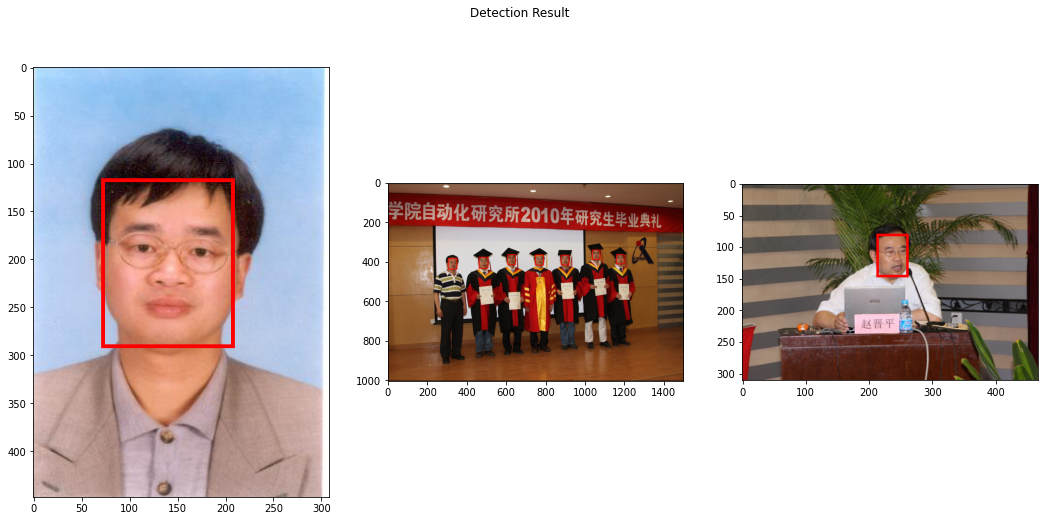

In [153]:
fig = plt.figure(figsize = (18,8))
fig.tight_layout()
fig.suptitle('Detection Result')

for i, img_sample in enumerate(tracked_faces):
  fig.add_subplot(1, img_c, i+1)
  plt.imshow(img_sample)

plt.show()

#### **Demo cropped Face**

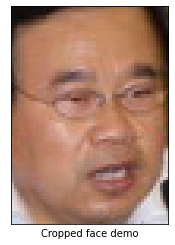

In [172]:
# sample image open
img = Image.open(os.path.join(class_path, os.listdir(class_path)[2]))

# detect faces
boxes, _ = mtcnn.detect(img)

cropped_face = img.crop(boxes[0].tolist())

plt.imshow(cropped_face)
plt.xlabel('Cropped face demo')
plt.xticks([])
plt.yticks([])

plt.show()